# SurvivalStan

Tutorial: http://www.hammerlab.org/2017/06/26/introducing-survivalstan/

TODO

- [] Plot divergent transitions for different runs with different options
- [] Run model independent of SurvivalStan so that I can reparametrize
- [] Change prior ranges
- [] Reparametrize

## Set up environment

In [1]:
# Install Stan utilities

!rm stan_utility.py
!wget https://raw.githubusercontent.com/betanalpha/jupyter_case_studies/master/pystan_workflow/stan_utility.py
    

# Upgrade pip
!pip3 install --user --upgrade pip


# Install PyStan
!pip3 install --user pystan


# Install SurvivalStan
!git clone https://github.com/hammerlab/survivalstan.git
!pip3 uninstall --yes survivalstan
!pip3 install --user survivalstan/.

--2019-07-26 04:20:51--  https://raw.githubusercontent.com/betanalpha/jupyter_case_studies/master/pystan_workflow/stan_utility.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.112.133
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.112.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5593 (5.5K) [text/plain]
Saving to: ‘stan_utility.py’

stan_utility.py     100%[===================>]   5.46K  --.-KB/s    in 0s      

2019-07-26 04:20:51 (135 MB/s) - ‘stan_utility.py’ saved [5593/5593]

Requirement already up-to-date: pip in /home/arnoldp9/.local/lib/python3.6/site-packages (19.2.1)
fatal: destination path 'survivalstan' already exists and is not an empty directory.
Uninstalling survivalstan-0.1.2.8:
  Successfully uninstalled survivalstan-0.1.2.8
Processing ./survivalstan


  Created wheel for survivalstan: filename=survivalstan-0.1.2.8-py2.py3-none-any.whl size=51505 sha256=fd50a6ae94fc254b946ca976d6ce83ae564cc188a5aff00ff4e11358eb406c33
  Stored in directory: /tmp/pip-ephem-wheel-cache-pppmt68c/wheels/14/78/50/ed05ddb3d2941b402a3072e01785737037153416a42ab1bdac
Successfully built survivalstan


In [2]:
import sys
import os

import math

import numpy as np
import pandas as pd

%matplotlib inline
from matplotlib import pyplot as plt

import pystan
import survivalstan
import stan_utility

## Simple exponential model with covariates

This serves as a simple sanity check.

$S(t) = \exp( -at ) \exp( \beta \cdot X )$

The following prior strategy will be used:

* Priors for established risk factors
* Priors for factor with more uncertain relevance

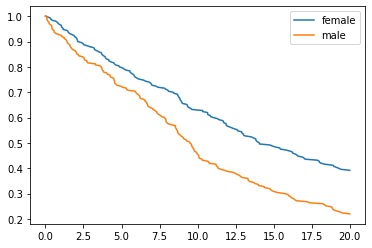

In [3]:
# Simulate Data
df2 = survivalstan.sim.sim_data_exp_correlated(
    N=500, censor_time=20, rate_form='1 + sex', rate_coefs=[-3, 0.5])


survivalstan.utils.plot_observed_survival(
    df2.query('sex == "female"'),
    time_col='t',
    event_col='event',
    label='female')

survivalstan.utils.plot_observed_survival(
    df2.query('sex == "male"'),
    time_col='t',
    event_col='event',
    label='male')

plt.legend()

In [ ]:
# Define runs
runs = {'q': [  200, 1,  150, 0.8],
        '1': [ 2000, 4, 1500, 0.8],
        '2': [ 2000, 4, 1500, 0.99],
        '3': [10000, 4, 9000, 0.99], 
        '4': [5000,  8, 4500, 0.99] }

In [5]:
# Infer parameters
def infer_params(Niter = 2000, Nchains = 2, Nwarmup = 1500, Nadapt_delta = 0.9):

    ctrl = dict(adapt_delta = Nadapt_delta,
                max_treedepth = 20)

    fit2_org = survivalstan.fit_stan_survival_model(
        df=df2,
        time_col='t',
        event_col='event',
        model_code=survivalstan.models.exp_survival_model,
        formula='~ age + sex',
        model_cohort = 'exp model',
        iter = Niter,
        chains = Nchains,
        warmup = Nwarmup,
        control = ctrl)
    
    return fit2_org


# Plot divergent transitions
def div_trans_beta(fit):
    
    light="#DCBCBC"
    light_highlight="#C79999"
    mid="#B97C7C"
    mid_highlight="#A25050"
    dark="#8F2727"
    dark_highlight="#7C0000"
    green="#00FF00"

    nondiv_params, div_params = stan_utility.partition_div(fit)

    plt.scatter([x[0] for x in nondiv_params['beta']], 
                [x[1] for x in nondiv_params['beta']], \
                 color = mid_highlight, alpha=0.05)
    plt.scatter([x[0] for x in div_params['beta']],
                [x[1] for x in div_params['beta']], \
                 color = green, alpha=0.5)

    plt.gca().set_xlabel("beta_1")
    plt.gca().set_ylabel("beta_2")

    plt.show()
    
    
def div_trans_tau_s(fit):
    
    light="#DCBCBC"
    light_highlight="#C79999"
    mid="#B97C7C"
    mid_highlight="#A25050"
    dark="#8F2727"
    dark_highlight="#7C0000"
    green="#00FF00"

    nondiv_params, div_params = stan_utility.partition_div(fit)

    plt.scatter([x[0] for x in nondiv_params['beta']], 
                np.log(nondiv_params['tau_s_raw']), \
                color = mid_highlight, alpha=0.05)
    
    plt.scatter([x[0] for x in div_params['beta']],
                np.log(div_params['tau_s_raw']), \
                color = green, alpha=0.5)

    plt.gca().set_xlabel("beta_1")
    plt.gca().set_ylabel("log tau_s_raw")

    plt.show()
    
    
def div_trans_alpha(fit):
    
    light="#DCBCBC"
    light_highlight="#C79999"
    mid="#B97C7C"
    mid_highlight="#A25050"
    dark="#8F2727"
    dark_highlight="#7C0000"
    green="#00FF00"

    nondiv_params, div_params = stan_utility.partition_div(fit)

    plt.scatter(nondiv_params['alpha'], 
                np.log(nondiv_params['tau_s_raw']), \
                color = mid_highlight, alpha=0.05)
    
    plt.scatter(div_params['alpha'],
                np.log(div_params['tau_s_raw']), \
                color = green, alpha=0.5)

    plt.gca().set_xlabel("alpha")
    plt.gca().set_ylabel("log tau_s_raw")

    plt.show()
    
    
def plot_div_trans(fit):
    div_trans_beta(fit)
    div_trans_tau_s(fit)
    div_trans_alpha(fit)
    
    
def run_all(key):
    params = runs[key]

    print(params)

    # Fit params
    res = infer_params(Niter = params[0], 
                       Nchains = params[1], 
                       Nwarmup = params[2], 
                       Nadapt_delta = params[3])

    # Show coefs
    coefs = survivalstan.utils.filter_stan_summary([res], pars=['lp__', 
                                                                     'alpha', 
                                                                     'beta', 
                                                                     'tau_s_raw', 
                                                                     'tau_raw'])
    print(coefs)

    # Diagnostics
    pystan.check_hmc_diagnostics(res['fit'])

    # Divergent transitions
    plot_div_trans(res['fit'])

    print("=============================")

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_0176fed484efbd961d78e8973c25ff98 NOW.


[200, 1, 150, 0.8]
NOT reusing model.


To run all diagnostics call pystan.check_hmc_diagnostics(fit)


Ran in 88.755 sec.
                   mean   se_mean         sd         2.5%          50%  \
lp__       -1328.877490  0.566026   2.057386 -1333.347581 -1328.672701   
alpha          0.033688  0.003254   0.018562     0.013132     0.026745   
beta[1]        0.449919  0.025375   0.137988     0.199030     0.446076   
beta[2]        0.008143  0.001416   0.008430    -0.011548     0.009803   
tau_s_raw      0.458504  0.100695   0.329521     0.034513     0.402531   
tau_raw[1]     7.117391  4.549947  20.643070     0.197172     1.335911   
tau_raw[2]     1.463866  0.356639   1.805696     0.150531     0.631749   

                  97.5%      Rhat  
lp__       -1325.806370  1.067220  
alpha          0.086120  1.001354  
beta[1]        0.682672  1.038908  
beta[2]        0.021041  1.007537  
tau_s_raw      1.148282  1.109251  
tau_raw[1]    89.448634  1.030590  
tau_raw[2]     6.753137  1.006646  


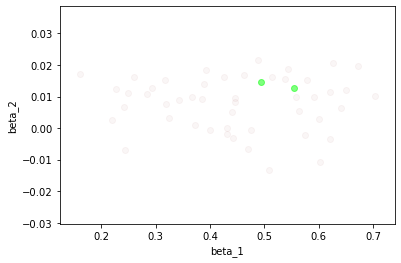

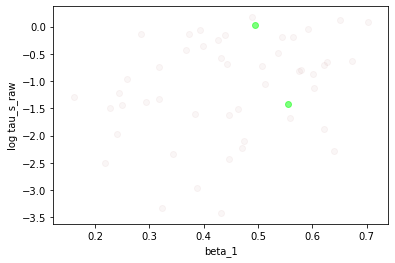

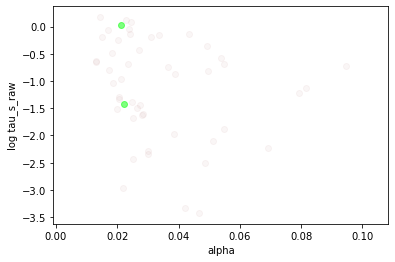

In [6]:
run_all('q')

[2000, 4, 1500, 0.8]
Reusing model.


To run all diagnostics call pystan.check_hmc_diagnostics(fit)


Ran in 50.755 sec.
                   mean     se_mean            sd         2.5%          50%  \
lp__       -1329.463333    0.762837      2.680263 -1335.745106 -1329.016277   
alpha          0.037839    0.001092      0.016501     0.014987     0.036861   
beta[1]        0.433009    0.013439      0.109680     0.218438     0.436346   
beta[2]        0.005714    0.000491      0.007198    -0.008877     0.004911   
tau_s_raw      0.245026    0.047924      0.176001     0.012673     0.216416   
tau_raw[1]  1175.908680  684.298847  26339.875870     0.364995     4.943096   
tau_raw[2]     1.528682    0.262598      3.774163     0.131001     0.674024   

                  97.5%      Rhat  
lp__       -1325.915713  1.166343  
alpha          0.078765  1.005349  
beta[1]        0.642194  1.057159  
beta[2]        0.020665  1.013761  
tau_s_raw      0.629374  1.152653  
tau_raw[1]  1572.734464  1.000856  
tau_raw[2]     9.859713  1.014986  


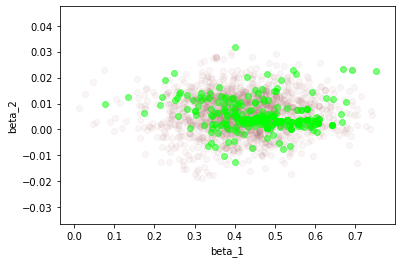

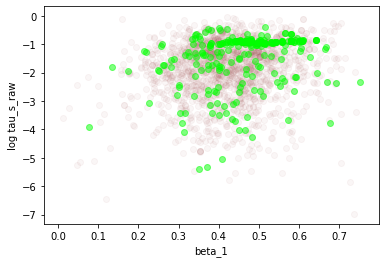

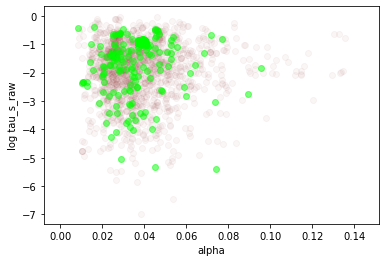

In [7]:
run_all('1')

[2000, 4, 1500, 0.99]
Reusing model.


To run all diagnostics call pystan.check_hmc_diagnostics(fit)
/home/arnoldp9/.local/lib/python3.6/site-packages/pystan/diagnostics.py:213: RuntimeWarning: overflow encountered in square
  numer = ((np.diff(energies, axis=0)**2).sum(axis=0)) / chain_len
/opt/conda/lib/python3.6/site-packages/numpy/core/_methods.py:121: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/home/arnoldp9/.local/lib/python3.6/site-packages/pystan/diagnostics.py:217: RuntimeWarning: invalid value encountered in true_divide
  e_bfmi = numer / denom


Ran in 186.744 sec.
                     mean    se_mean          sd           2.5%           50%  \
lp__       -3.765809e+265        NaN         inf -3.300394e+266 -2.110530e+50   
alpha        1.878134e+00   1.313383    1.858355   1.610623e-02  1.747527e+00   
beta[1]     -4.633330e-01   0.650644    0.923482  -1.608968e+00 -5.390871e-01   
beta[2]      2.347244e+00   2.301626    3.256658  -4.240482e-03  7.459375e-01   
tau_s_raw    2.657937e+00   1.625186    2.373189   4.081104e-02  2.830246e+00   
tau_raw[1]   2.878243e+01  11.213144  242.700129   2.848674e-01  1.988974e+00   
tau_raw[2]   4.131141e+00   1.764520    3.405923   1.721607e-01  5.929222e+00   

                  97.5%        Rhat  
lp__       -1324.892930         NaN  
alpha          4.043092  201.059058  
beta[1]        0.629462   12.239621  
beta[2]        7.915089  347.945096  
tau_s_raw      6.335794    4.056191  
tau_raw[1]   170.266339    1.016831  
tau_raw[2]     7.096753    1.477654  


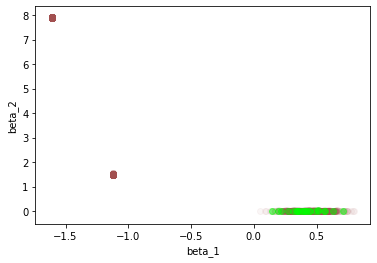

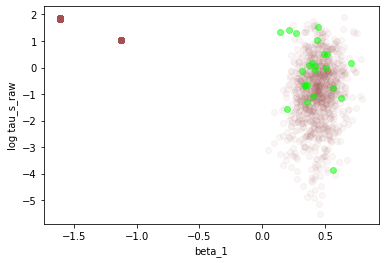

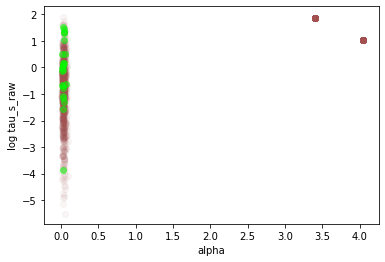

In [8]:
run_all('2')

[10000, 4, 9000, 0.99]
Reusing model.


To run all diagnostics call pystan.check_hmc_diagnostics(fit)


Ran in 2285.785 sec.


                    mean       se_mean            sd          2.5%  \
lp__       -4.192308e+32  4.716016e+32  1.233986e+33 -5.766400e+33   
alpha       1.303135e+00  1.550498e+00  2.193320e+00  1.564354e-02   
beta[1]     9.636198e-01  6.565664e-01  9.328172e-01  2.184371e-01   
beta[2]     2.317090e-01  2.760757e-01  3.906766e-01 -7.238172e-03   
tau_s_raw   1.554268e+00  9.756006e-01  1.647588e+00  3.107536e-02   
tau_raw[1]  5.950949e+01  1.745310e+01  8.372645e+02  1.438865e-01   
tau_raw[2]  3.385674e+00  1.127783e+00  3.104161e+01  1.454092e-01   

                    50%        97.5%        Rhat  
lp__       -1329.238395 -1324.527299    1.661370  
alpha          0.041135     5.101523  165.708152  
beta[1]        0.475666     2.570239   10.222169  
beta[2]        0.009547     0.933795   51.257342  
tau_s_raw      0.697812     3.888536    1.830694  
tau_raw[1]     1.062028   232.514099    1.002797  
tau_raw[2]     1.187718     9.832554    1.003443  


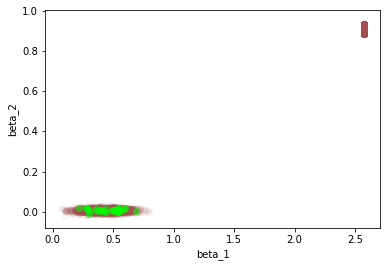

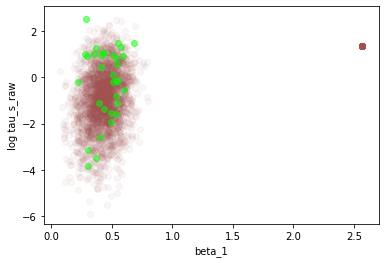

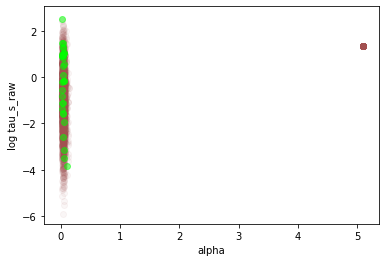

In [9]:
run_all('3')

In [ ]:
run_all('4')

### Reproduce results without SurvivalStan

In [ ]:
run3 = infer_params(Niter = 5000, Nchains = 4, Nwarmup = 4500, Nadapt_delta = 0.9999)

survivalstan.utils.filter_stan_summary([run3], pars=['lp__', 'alpha', 'beta', 'tau_s_raw', 'tau_raw'])

pystan.check_hmc_diagnostics(run3['fit'])

div_trans_beta(run3['fit'])
div_trans_tau_s(run3['fit'])

Reusing model.


## More flexible baseline hazards: Piecewise hazard

One of the more critical parameterizations to get right is that of the baseline hazard. The baseline hazard behaves like an intercept in a typical regression model. It describes the instantaneous hazard over time for the population in the absence of any covariate effects. Failure to get this right can lead to all sorts of pathologies whereby the excess variation in hazard not accounted for by your modeled baseline hazard will be absorbed into covariate effects, yielding invalid inferences and potentially misleading conclusions.

*Aside: This is not a concern when using a Cox PH model for example, because the coefficient values are estimated using Maximum Likelihood Estimation (MLE) on a partial likelihood which does not include the baseline hazard. In a Bayesian analysis, however, we have the challenge of estimating the hazard as well as the coefficient effects.*

Most of the time, we do not have a prior belief on the distribution of the baseline hazard. We usually do not care that much about what the features of the baseline hazard look like (although perhaps we should!). Instead, we are concerned with making sure our inferences about coefficient values are valid.

We thus want a baseline hazard that is sufficiently flexible to absorb any variation in the hazard over time which should not be attributed to covariate values. We also however want to minimize the risk of overfitting, so that our posterior predicted probabilities of survival are well calibrated. Many of the semi- or non-parametric approaches to modeling baseline hazards are very flexible with a penalty to impose the upper bound of complexity.

Piecewise-Exponential Model: https://data.princeton.edu/wws509/notes/c7s4